### Code to accompany post [Universal Function Approximation using TensorFlow](http://deliprao.com/archives/100)

In [1]:
import tensorflow as tf
import numpy as np
import math, random
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

A $40\times{40}$ network with two hidden layers gets to MSE $1.17$ after $2,300$ epochs, and never gets better. A network with one hidden layer of $40$ nodes gets to MSE $1.32$ after $10,000$ epochs, and is still improving. The $40\times{40}$ network achieves MSE $1.32$ somewhere between $1,000$ and $1,100$ epochs, when it is still improving rapidly.

A $20\times{20}$ network doesn't coverge well after $6,000$ epochs.

### Find out about environments

The following is not a reliable method, and doesn't port to Python 2.7, nor (possibly) in every sub-version of Python 3. It's really here just to tell us the name of the environment we're in, in the case we're missing some packages and need to troubleshoot the environment. See https://goo.gl/EXq7pE.

In [3]:
import sys
import os
if 'CONDA_DEFAULT_ENV' in os.environ:
    print(f"running in conda environment {os.environ['CONDA_DEFAULT_ENV']}")
else:
    print("not running in a conda environment")

if hasattr(sys, 'real_prefix'):
    print(f"sys has real_prefix {sys.real_prefix}")
else:
    print("sys has no real_prefix")

if hasattr(sys, 'base_prefix'):
    print(f"sys has base_prefix {sys.base_prefix}")
else:
    print("sys has no base_prefix")

if hasattr(sys, 'prefix'):
    print(f"sys has prefix {sys.prefix}")
else:
    print("sys has no prefix")

running in conda environment unifax
sys has no real_prefix
sys has base_prefix /home/rebcabin/anaconda3/envs/unifax
sys has prefix /home/rebcabin/anaconda3/envs/unifax


### Hyperparameters and constants

The two-layer netword with 40 nodes in each layer achieves 1.41 MSE by epoch 1500, whereas, with 20 nodes in each layer, achieves only 2.03.

In [4]:
np.random.seed(1000) # for repro

function_to_learn = lambda x: np.sin(x) + 0.1 * np.random.randn(*x.shape)

NUM_HIDDEN_NODES = 40

NUM_NODES_LAYER_1 = 40
NUM_NODES_LAYER_2 = 40

NUM_EXAMPLES = 1000
TRAIN_SPLIT = .8
MINI_BATCH_SIZE = 100
NUM_EPOCHS = 10000

In [5]:
def uniform_scrambled_col_vec(left, right, dim):
    return np.random.uniform(left, right, (1, dim)).T

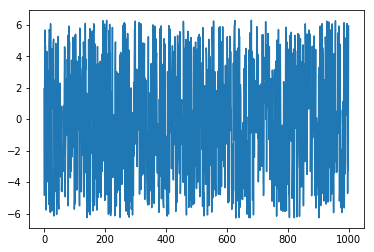

In [6]:
all_x = uniform_scrambled_col_vec(-2 * np.pi, 2 * np.pi, NUM_EXAMPLES)
plt.plot(all_x.T[0]);

Not sure why the original author shuffled the $x$ array. Looks like it was already shuffled.

The original is now marked as a raw cell. Mark it 'y' for code if you want to execute it.

In [7]:
def make_data_sets(xs, func, num_examples, train_split):
    train_size = int(num_examples * train_split)
    trainx = all_x[:train_size]
    validx = all_x[train_size:]
    return trainx, func(trainx), validx, func(validx)

In [9]:
trainx, trainy, validx, validy = \
    make_data_sets(
        all_x, 
        function_to_learn, 
        NUM_EXAMPLES, 
        TRAIN_SPLIT)

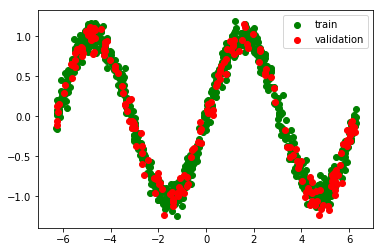

In [10]:
plt.figure(1)
plt.scatter(trainx, trainy, c='green', label='train')
plt.scatter(validx, validy, c='red', label='validation')
plt.legend();

In [9]:
X = tf.placeholder(tf.float32, [None, 1], name="X")
Y = tf.placeholder(tf.float32, [None, 1], name="Y")

The following makes a bunch of anonnymous TF global variables.

In [10]:
def init_weights(shape, init_method='xavier', xavier_params = (None, None)):
    if init_method == 'zeros':
        return tf.Variable(tf.zeros(shape, dtype=tf.float32))
    elif init_method == 'uniform':
        return tf.Variable(
            tf.random_normal(shape, stddev=0.01, dtype=tf.float32))
    else:  # xavier
        (fan_in, fan_out) = xavier_params
        blorp = 4 * np.sqrt(6.0 / (fan_in + fan_out))
        return tf.Variable(tf.random_uniform(
            shape, minval=-blorp, maxval=blorp, dtype=tf.float32))

In [11]:
the_model = None
the_model_2 = None

In [12]:
def model(X, num_hidden=10):
    global the_model
    w_h = init_weights([1, num_hidden], 'xavier', xavier_params=(1, num_hidden))
    b_h = init_weights([1, num_hidden], 'zeros')
    h = tf.nn.sigmoid(tf.matmul(X, w_h) + b_h)
    
    w_o = init_weights([num_hidden, 1], 'xavier', xavier_params=(num_hidden, 1))
    b_o = init_weights([1, 1], 'zeros')
    the_model = tf.matmul(h, w_o) + b_o
    return the_model

In [13]:
def model_2(X, num_h1=10, num_h2=10):
    global the_model_2
    w_h1 = init_weights([1, num_h1], 'xavier', xavier_params=(1, num_h1))
    b_h1 = init_weights([1, num_h1], 'zeros')
    h1 = tf.nn.sigmoid(tf.matmul(X, w_h1) + b_h1)
    
    w_h2 = init_weights([num_h1, num_h2], 'xavier', xavier_params=(num_h1, num_h2))
    b_h2 = init_weights([1, num_h2], 'zeros')
    h2 = tf.nn.sigmoid(tf.matmul(h1, w_h2) + b_h2)
    
    w_o = init_weights([num_h2, 1], 'xavier', xavier_params=(num_h2, 1))
    b_o = init_weights([1, 1], 'zeros')
    the_model_2 = tf.matmul(h2, w_o) + b_o
    return the_model_2

In [14]:
yhat = model(X, NUM_HIDDEN_NODES)
yhat_2 = model_2(X, NUM_NODES_LAYER_1, NUM_NODES_LAYER_2)

In [15]:
train_op = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(yhat - Y))
train_op_2 = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(yhat_2 - Y))

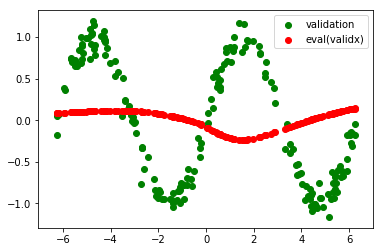

epoch 0, validation MSE  58.22


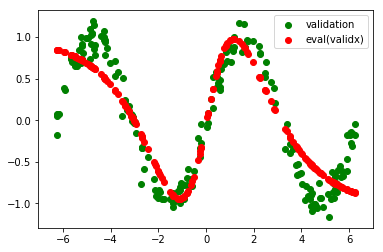

epoch 100, validation MSE   9.69


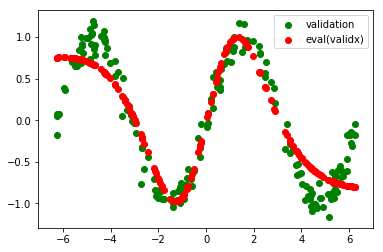

epoch 200, validation MSE   7.57


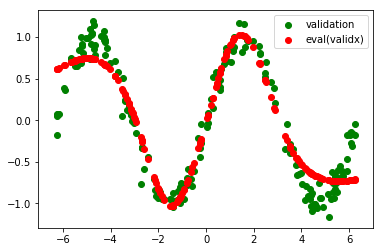

epoch 300, validation MSE   5.32


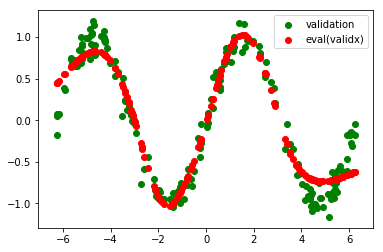

epoch 400, validation MSE   3.53


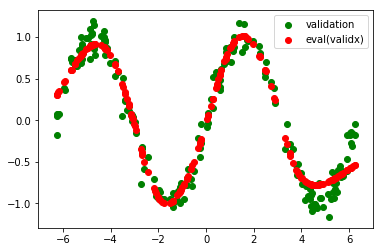

epoch 500, validation MSE   2.50


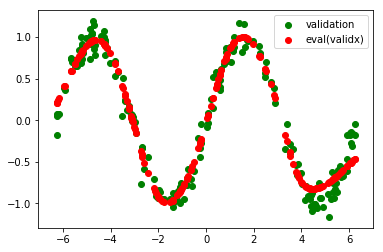

epoch 600, validation MSE   1.98


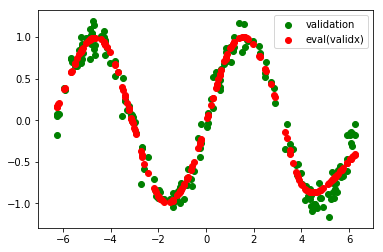

epoch 700, validation MSE   1.70


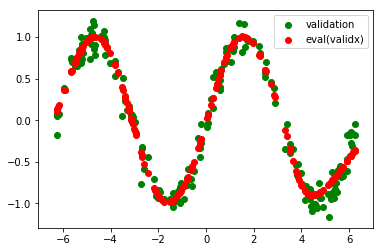

epoch 800, validation MSE   1.54


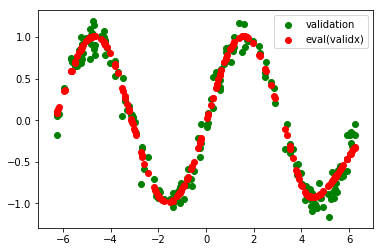

epoch 900, validation MSE   1.43


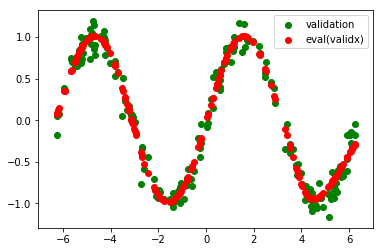

epoch 1000, validation MSE   1.35


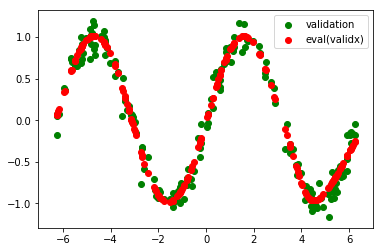

epoch 1100, validation MSE   1.30


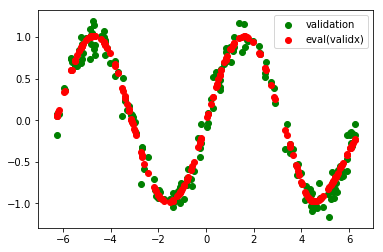

epoch 1200, validation MSE   1.26


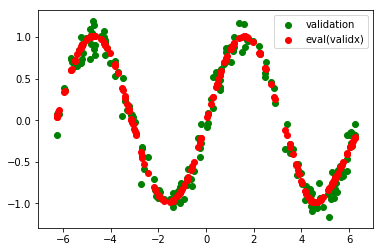

epoch 1300, validation MSE   1.23


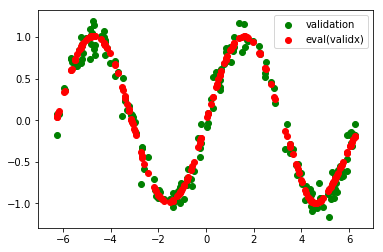

epoch 1400, validation MSE   1.22


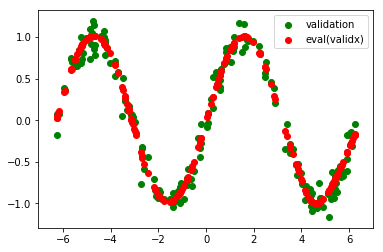

epoch 1500, validation MSE   1.20


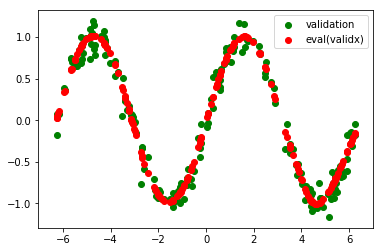

epoch 1600, validation MSE   1.19


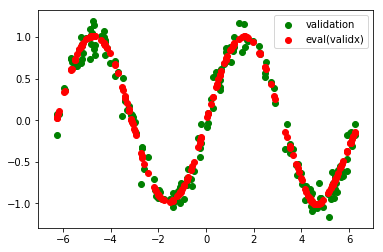

epoch 1700, validation MSE   1.19


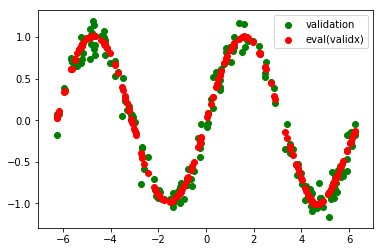

epoch 1800, validation MSE   1.18


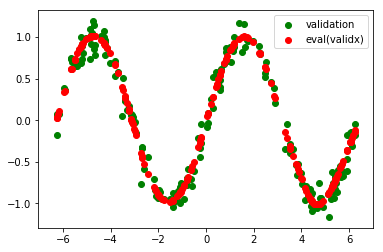

epoch 1900, validation MSE   1.18


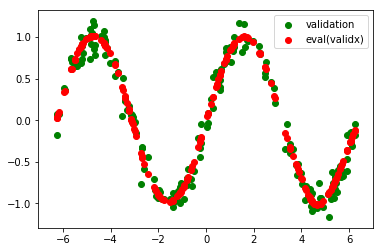

epoch 2000, validation MSE   1.18


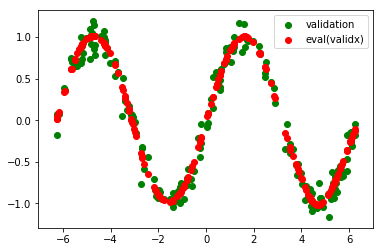

epoch 2100, validation MSE   1.18


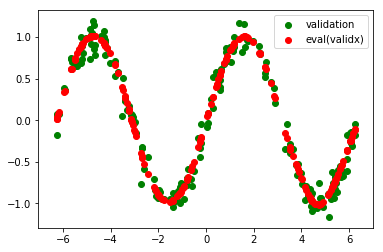

epoch 2200, validation MSE   1.18


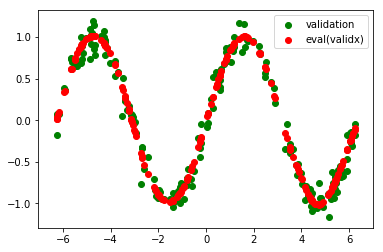

epoch 2300, validation MSE   1.17


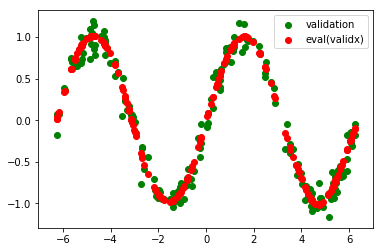

epoch 2400, validation MSE   1.17


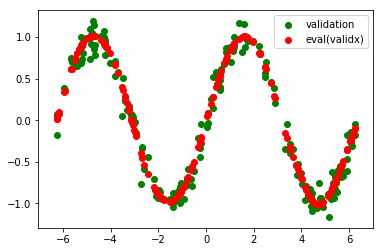

epoch 2500, validation MSE   1.17


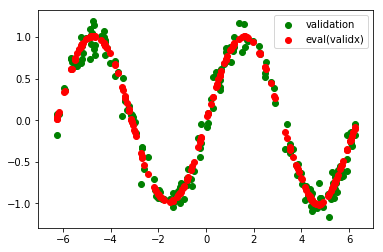

epoch 2600, validation MSE   1.17


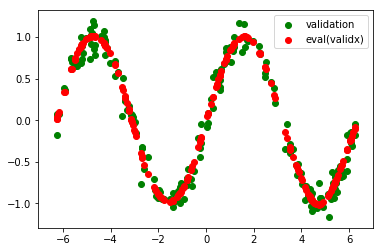

epoch 2700, validation MSE   1.17


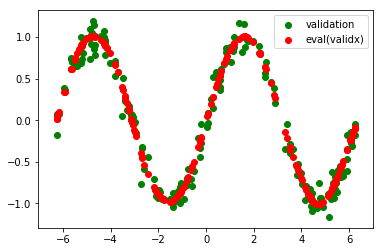

epoch 2800, validation MSE   1.17


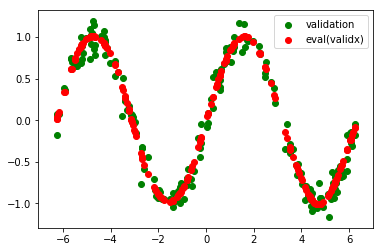

epoch 2900, validation MSE   1.17


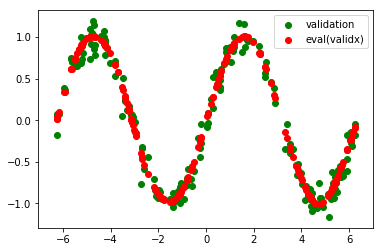

epoch 3000, validation MSE   1.17


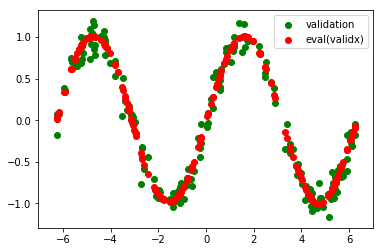

epoch 3100, validation MSE   1.17


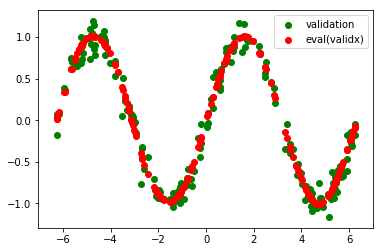

epoch 3200, validation MSE   1.17


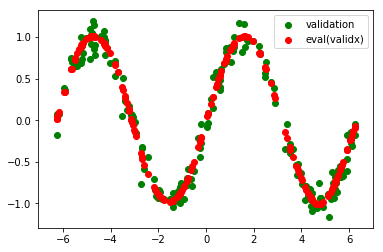

epoch 3300, validation MSE   1.17


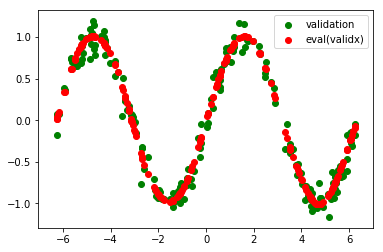

epoch 3400, validation MSE   1.17


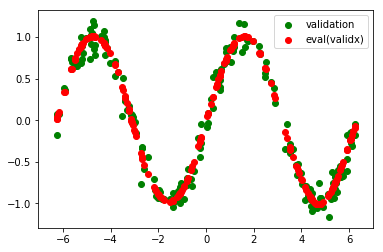

epoch 3500, validation MSE   1.17


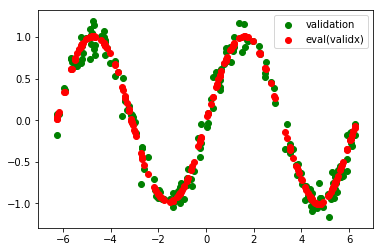

epoch 3600, validation MSE   1.17


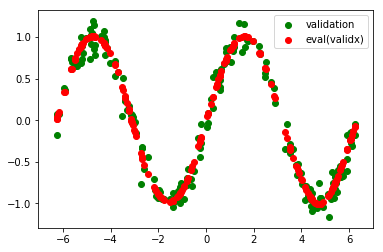

epoch 3700, validation MSE   1.17


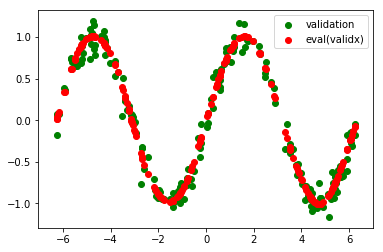

epoch 3800, validation MSE   1.17


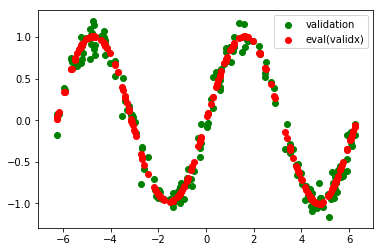

epoch 3900, validation MSE   1.17


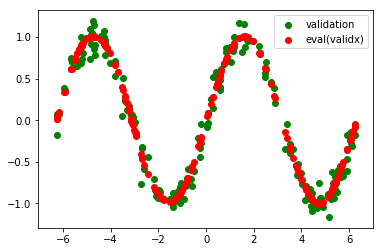

epoch 4000, validation MSE   1.17


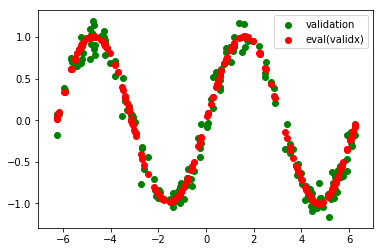

epoch 4100, validation MSE   1.17


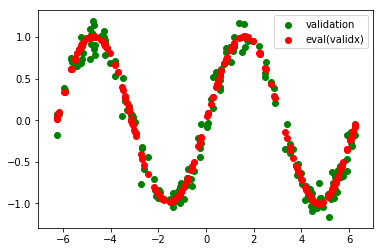

epoch 4200, validation MSE   1.17


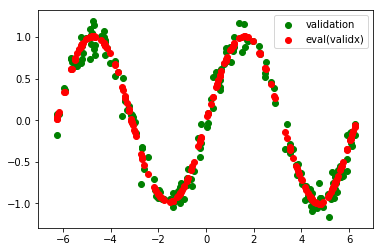

epoch 4300, validation MSE   1.17


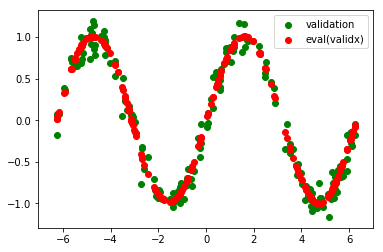

epoch 4400, validation MSE   1.17


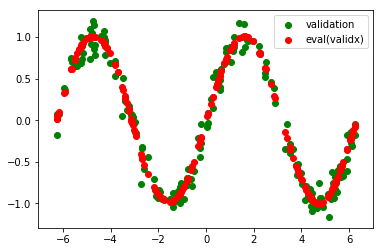

epoch 4500, validation MSE   1.17


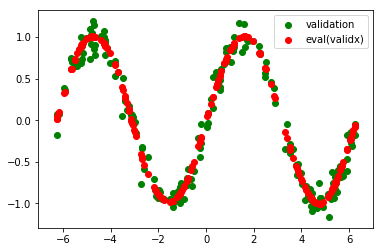

epoch 4600, validation MSE   1.17


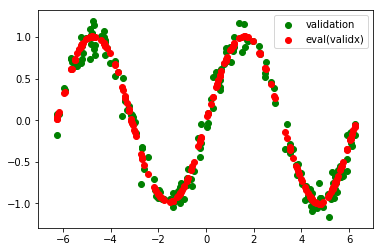

epoch 4700, validation MSE   1.17


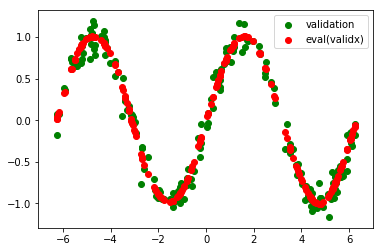

epoch 4800, validation MSE   1.17


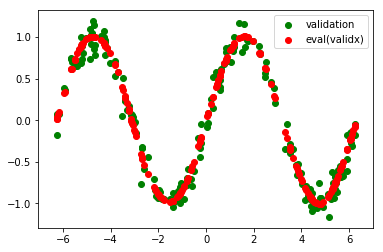

epoch 4900, validation MSE   1.17


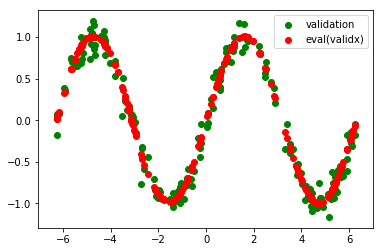

epoch 5000, validation MSE   1.17


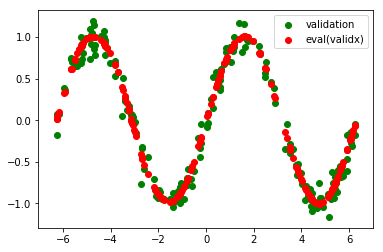

epoch 5100, validation MSE   1.17


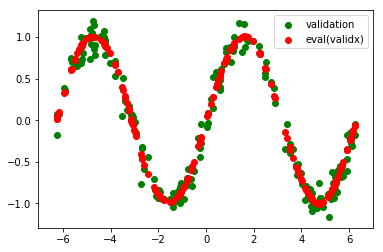

epoch 5200, validation MSE   1.17


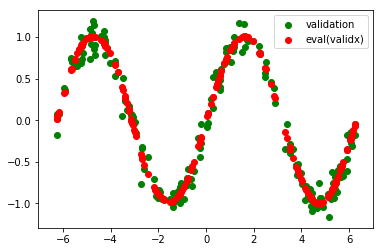

epoch 5300, validation MSE   1.17


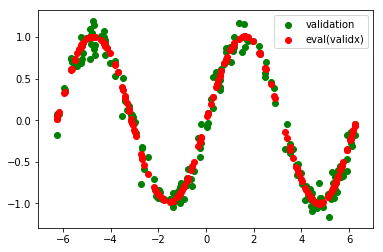

epoch 5400, validation MSE   1.17


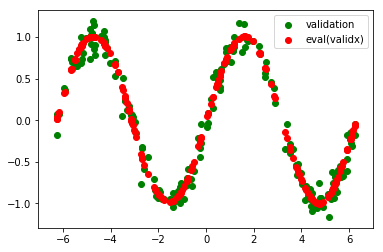

epoch 5500, validation MSE   1.17


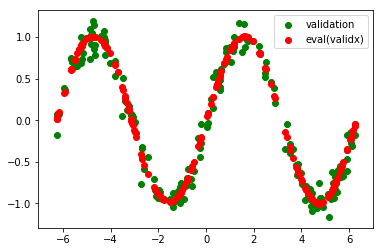

epoch 5600, validation MSE   1.17


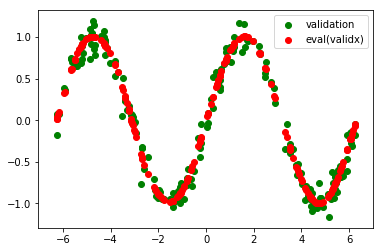

epoch 5700, validation MSE   1.17


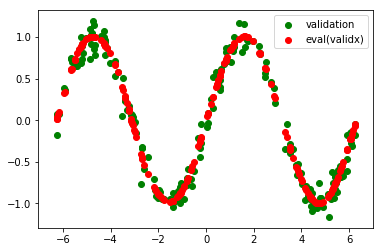

epoch 5800, validation MSE   1.17


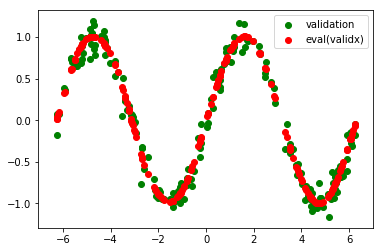

epoch 5900, validation MSE   1.17


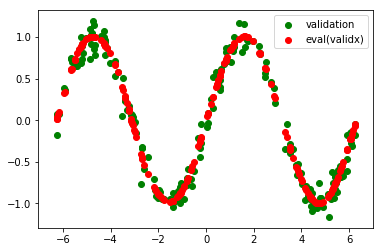

epoch 6000, validation MSE   1.17


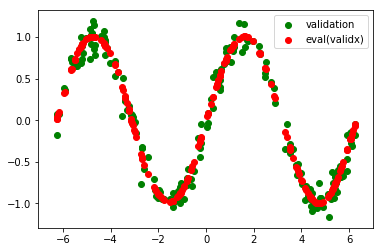

epoch 6100, validation MSE   1.17


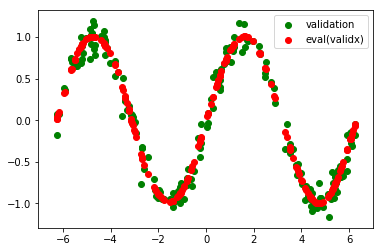

epoch 6200, validation MSE   1.17


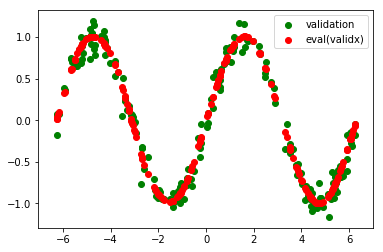

epoch 6300, validation MSE   1.17


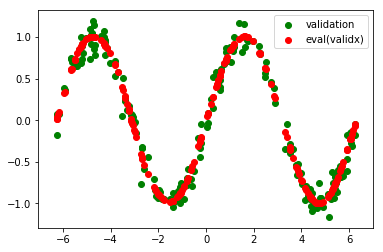

epoch 6400, validation MSE   1.17


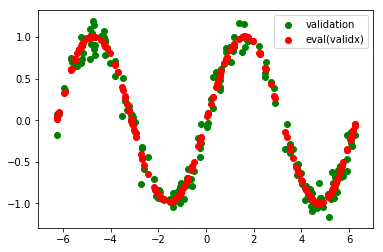

epoch 6500, validation MSE   1.17


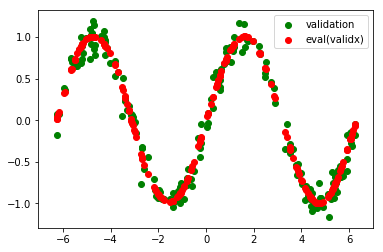

epoch 6600, validation MSE   1.17


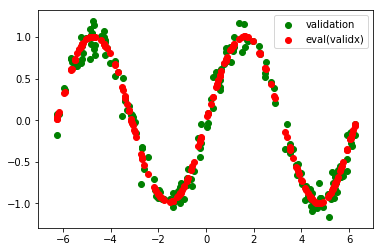

epoch 6700, validation MSE   1.17


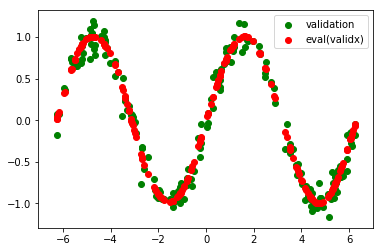

epoch 6800, validation MSE   1.17


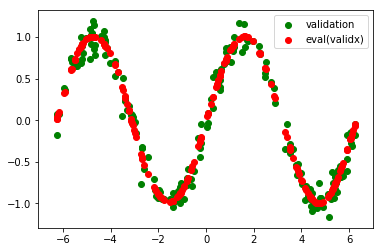

epoch 6900, validation MSE   1.17


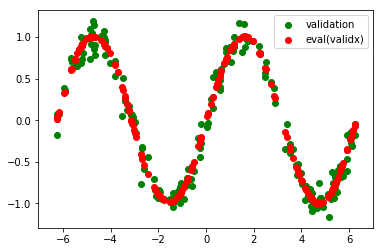

epoch 7000, validation MSE   1.17


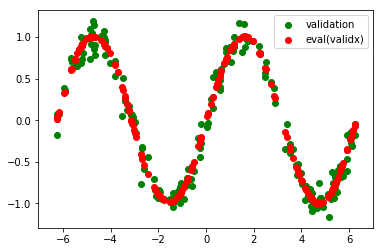

epoch 7100, validation MSE   1.17


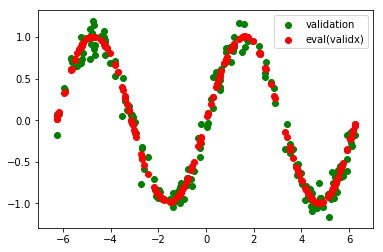

epoch 7200, validation MSE   1.17


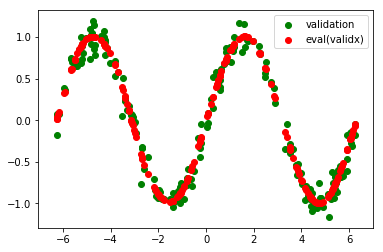

epoch 7300, validation MSE   1.17


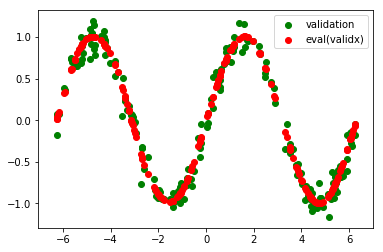

epoch 7400, validation MSE   1.17


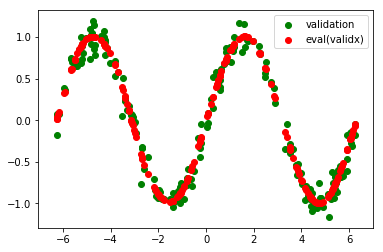

epoch 7500, validation MSE   1.17


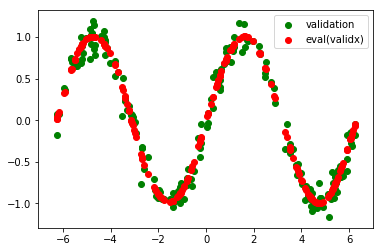

epoch 7600, validation MSE   1.17


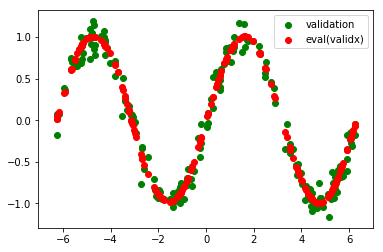

epoch 7700, validation MSE   1.17


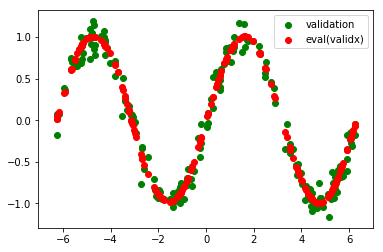

epoch 7800, validation MSE   1.17


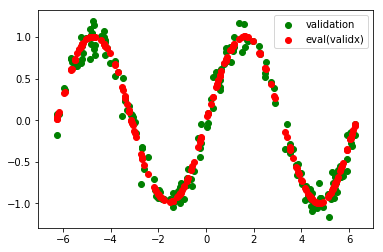

epoch 7900, validation MSE   1.17


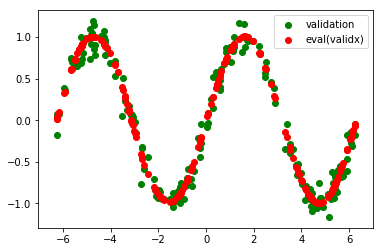

epoch 8000, validation MSE   1.17


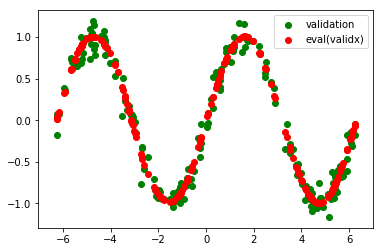

epoch 8100, validation MSE   1.17


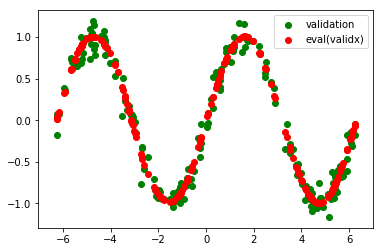

epoch 8200, validation MSE   1.17


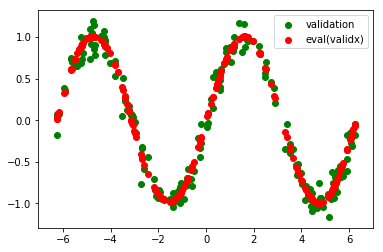

epoch 8300, validation MSE   1.17


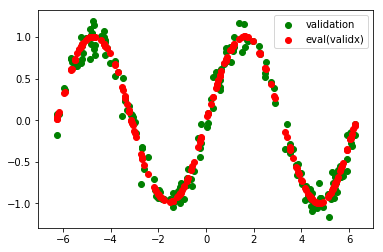

epoch 8400, validation MSE   1.17


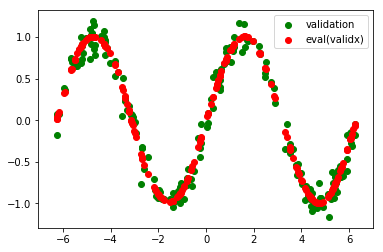

epoch 8500, validation MSE   1.17


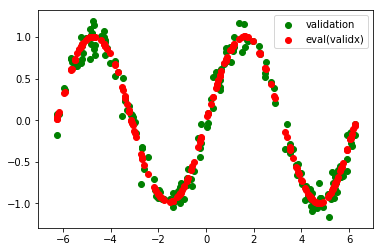

epoch 8600, validation MSE   1.17


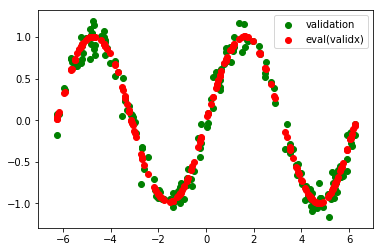

epoch 8700, validation MSE   1.17


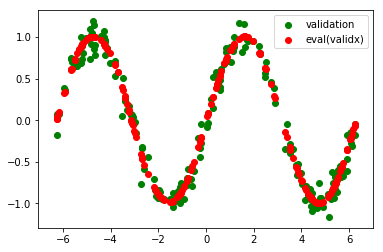

epoch 8800, validation MSE   1.17


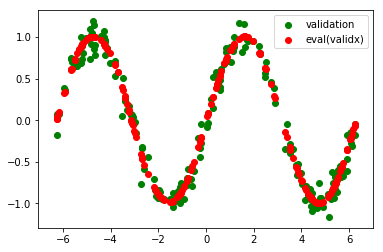

epoch 8900, validation MSE   1.17


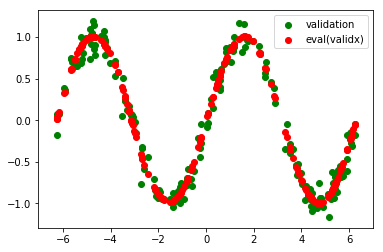

epoch 9000, validation MSE   1.17


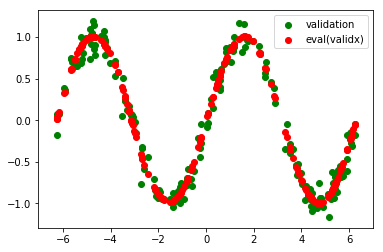

epoch 9100, validation MSE   1.17


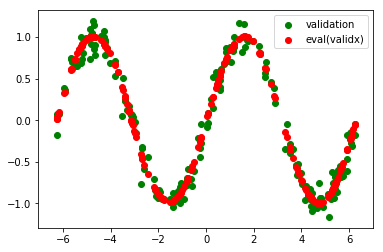

epoch 9200, validation MSE   1.17


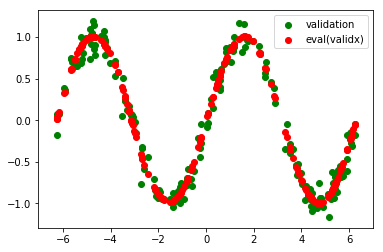

epoch 9300, validation MSE   1.17


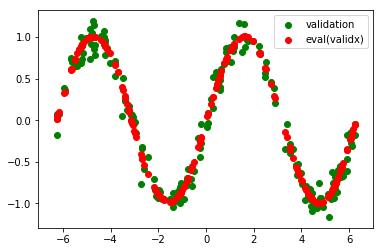

epoch 9400, validation MSE   1.17


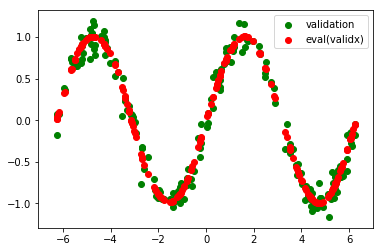

epoch 9500, validation MSE   1.17


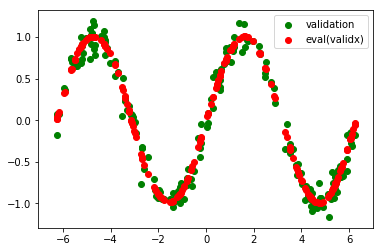

epoch 9600, validation MSE   1.17


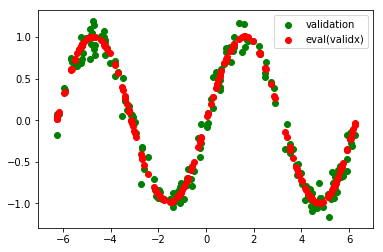

epoch 9700, validation MSE   1.17


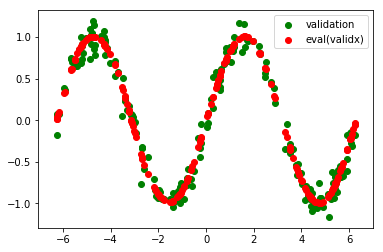

epoch 9800, validation MSE   1.17


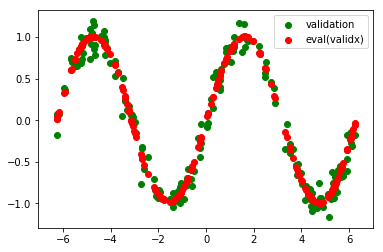

epoch 9900, validation MSE   1.17


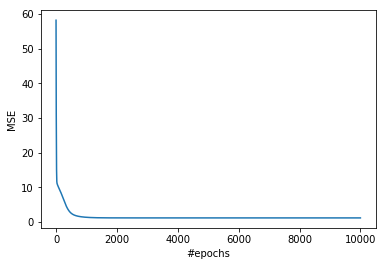

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    errors = []
    for i in range(NUM_EPOCHS):
        for start, end in zip(range(0, len(trainx), MINI_BATCH_SIZE), 
                              range(MINI_BATCH_SIZE, len(trainx), MINI_BATCH_SIZE)):
            sess.run(train_op_2, feed_dict={X: trainx[start:end], Y: trainy[start:end]})
        mse = sess.run(tf.nn.l2_loss(yhat_2 - validy), feed_dict={X:validx})
        errors.append(mse)
        if i % 100 == 0: 
            result = sess.run(the_model_2, feed_dict={X:validx})
            plt.figure(1)
            plt.scatter(validx, validy, c='green', label='validation')
            plt.scatter(validx, result, c='red', label='eval(validx)')
            plt.legend()
            plt.show()
            print(f"epoch {i}, validation MSE {mse:6.2f}")
        
plt.xlabel('#epochs')
plt.ylabel('MSE')
plt.plot(errors);

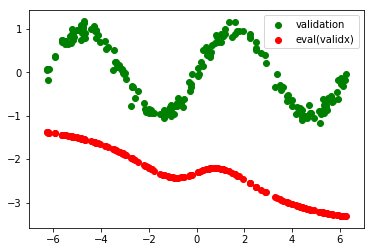

epoch 0, validation MSE 562.98


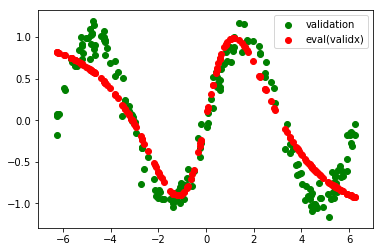

epoch 100, validation MSE  10.17


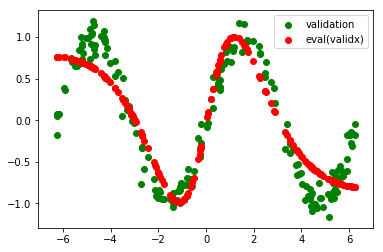

epoch 200, validation MSE   8.70


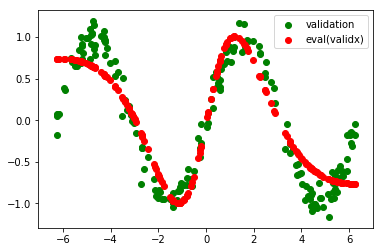

epoch 300, validation MSE   8.01


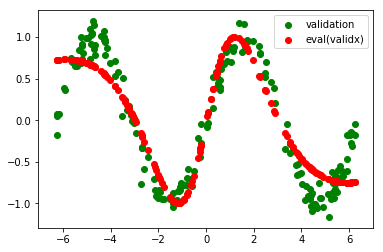

epoch 400, validation MSE   7.71


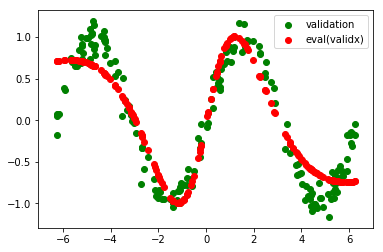

epoch 500, validation MSE   7.51


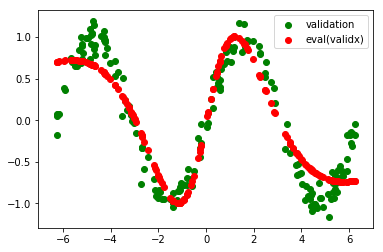

epoch 600, validation MSE   7.38


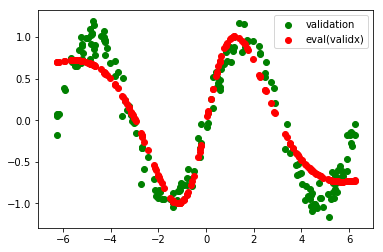

epoch 700, validation MSE   7.28


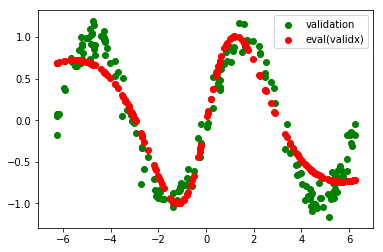

epoch 800, validation MSE   7.19


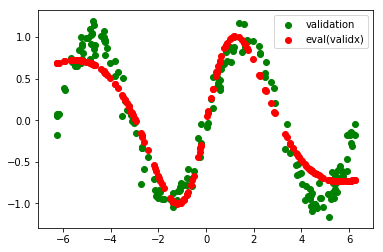

epoch 900, validation MSE   7.12


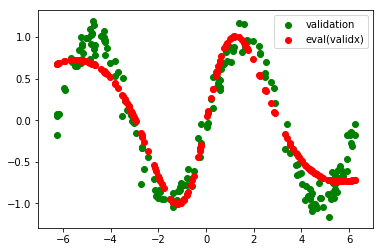

epoch 1000, validation MSE   7.04


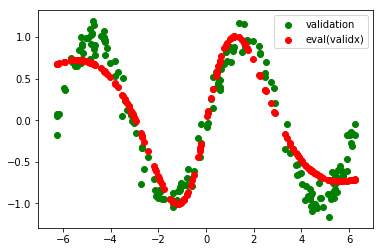

epoch 1100, validation MSE   6.97


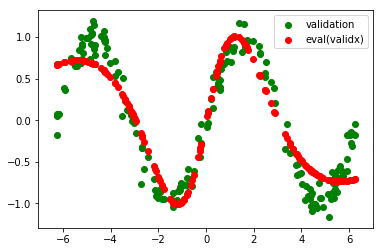

epoch 1200, validation MSE   6.89


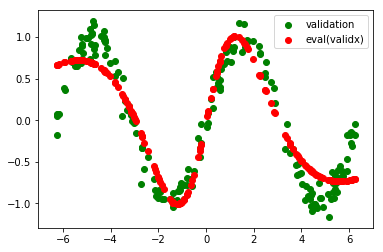

epoch 1300, validation MSE   6.81


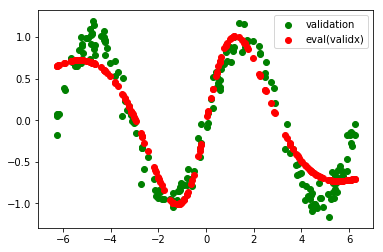

epoch 1400, validation MSE   6.70


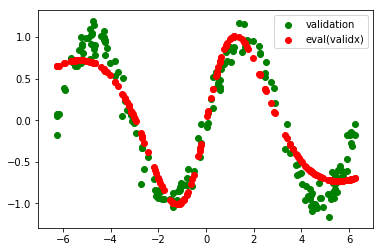

epoch 1500, validation MSE   6.56


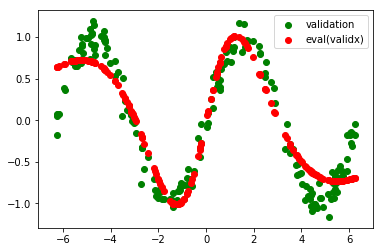

epoch 1600, validation MSE   6.36


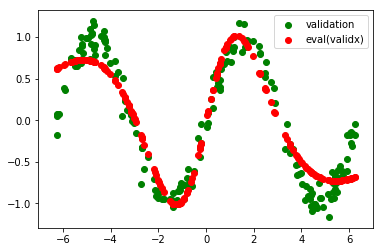

epoch 1700, validation MSE   6.09


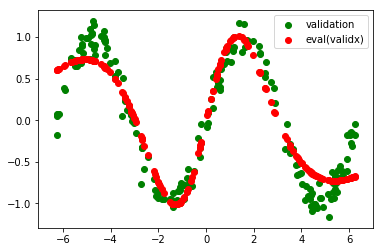

epoch 1800, validation MSE   5.74


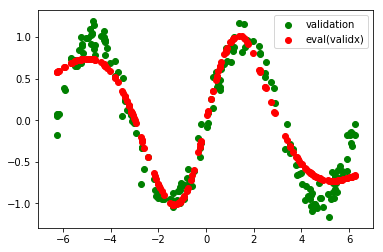

epoch 1900, validation MSE   5.34


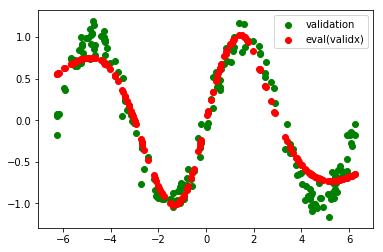

epoch 2000, validation MSE   4.90


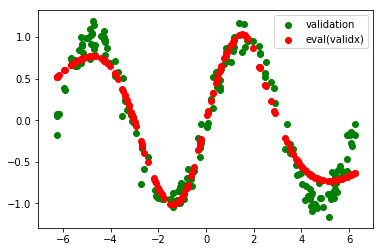

epoch 2100, validation MSE   4.45


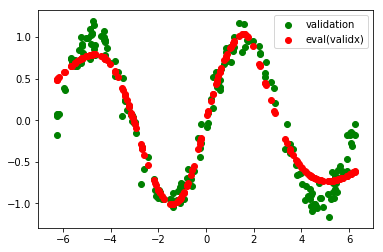

epoch 2200, validation MSE   4.03


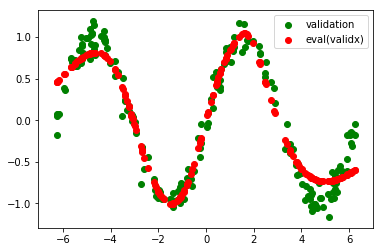

epoch 2300, validation MSE   3.67


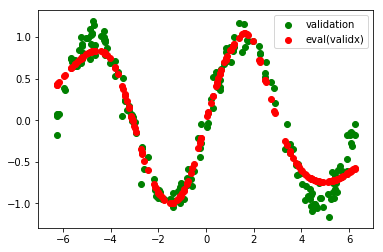

epoch 2400, validation MSE   3.37


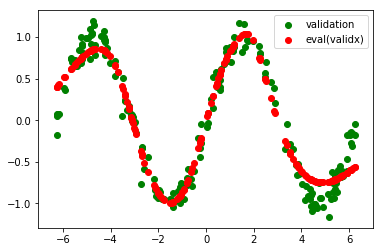

epoch 2500, validation MSE   3.12


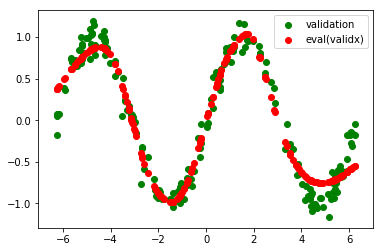

epoch 2600, validation MSE   2.93


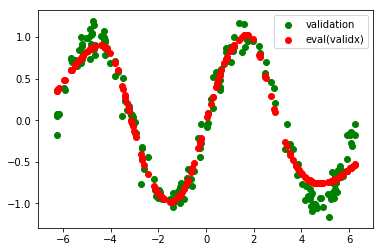

epoch 2700, validation MSE   2.78


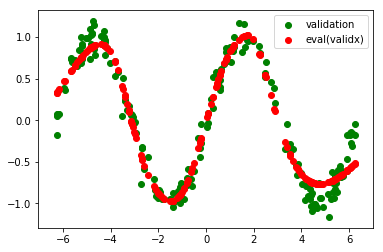

epoch 2800, validation MSE   2.65


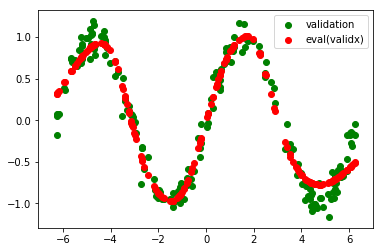

epoch 2900, validation MSE   2.55


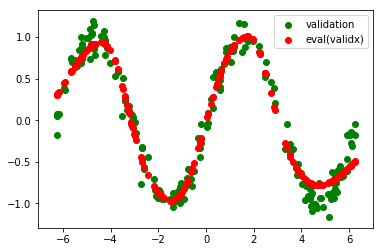

epoch 3000, validation MSE   2.47


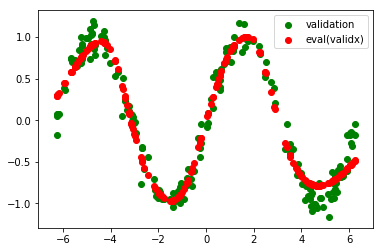

epoch 3100, validation MSE   2.39


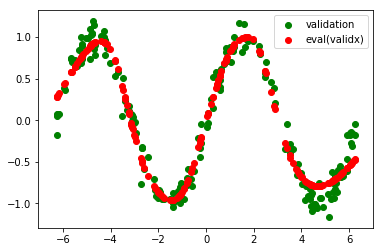

epoch 3200, validation MSE   2.33


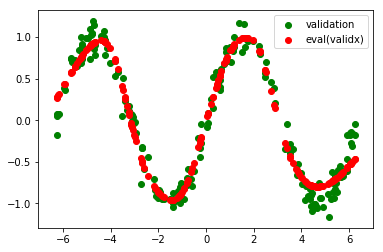

epoch 3300, validation MSE   2.27


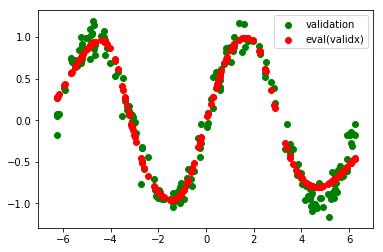

epoch 3400, validation MSE   2.22


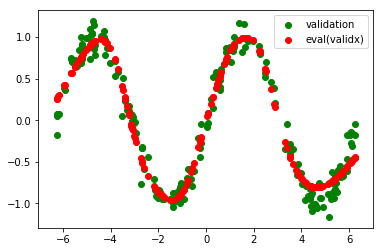

epoch 3500, validation MSE   2.18


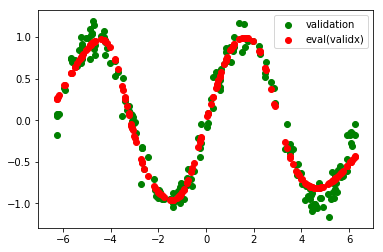

epoch 3600, validation MSE   2.14


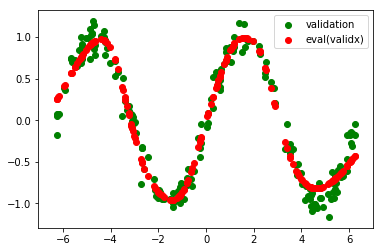

epoch 3700, validation MSE   2.10


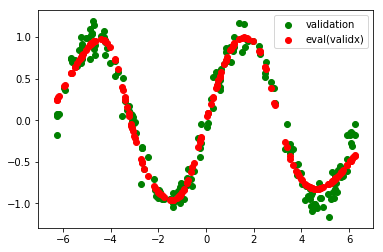

epoch 3800, validation MSE   2.06


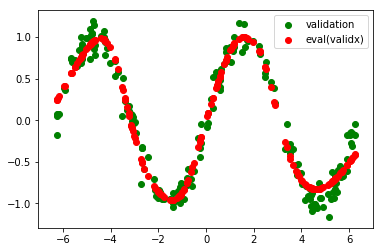

epoch 3900, validation MSE   2.03


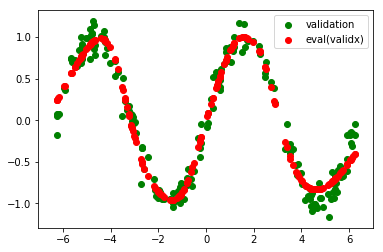

epoch 4000, validation MSE   1.99


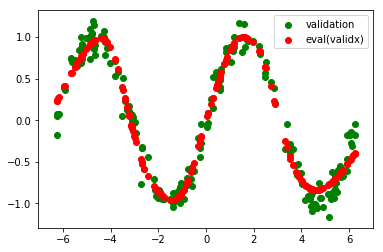

epoch 4100, validation MSE   1.96


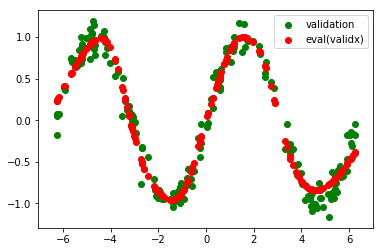

epoch 4200, validation MSE   1.93


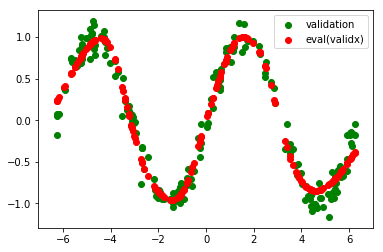

epoch 4300, validation MSE   1.90


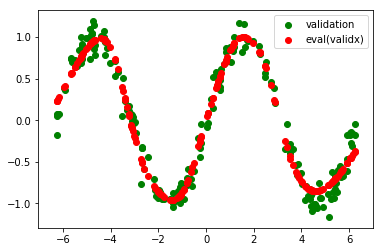

epoch 4400, validation MSE   1.88


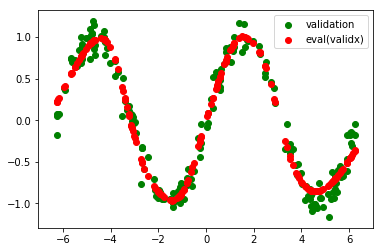

epoch 4500, validation MSE   1.85


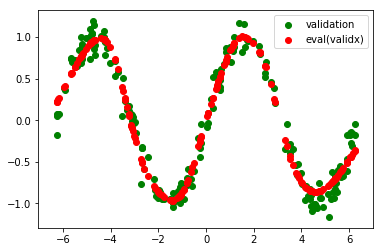

epoch 4600, validation MSE   1.83


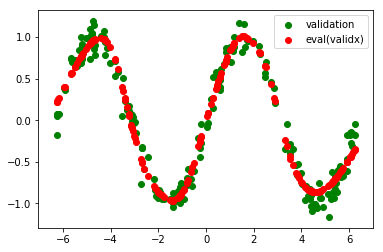

epoch 4700, validation MSE   1.81


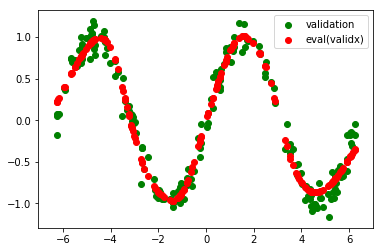

epoch 4800, validation MSE   1.78


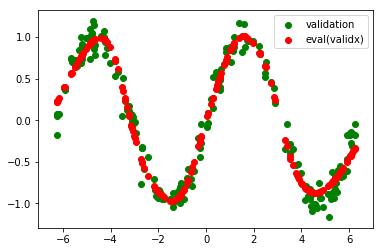

epoch 4900, validation MSE   1.76


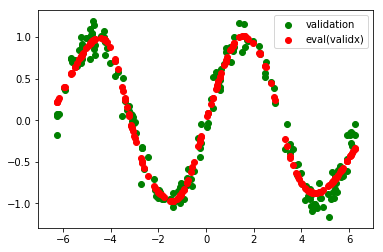

epoch 5000, validation MSE   1.74


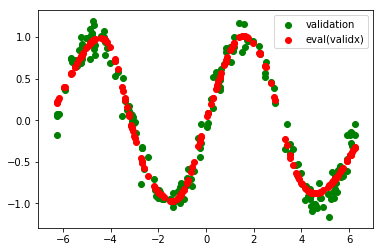

epoch 5100, validation MSE   1.72


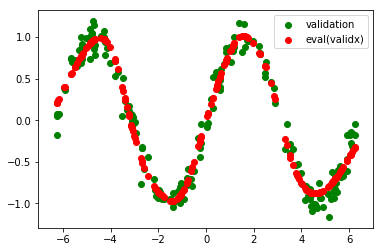

epoch 5200, validation MSE   1.71


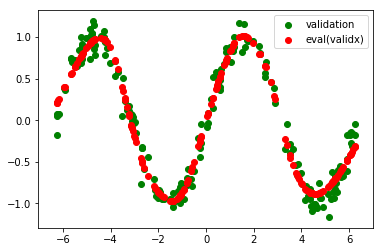

epoch 5300, validation MSE   1.69


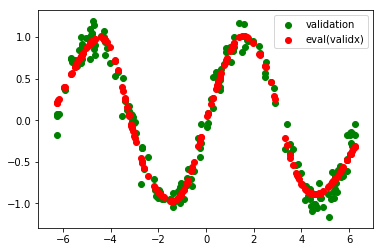

epoch 5400, validation MSE   1.67


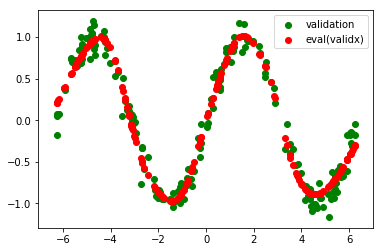

epoch 5500, validation MSE   1.66


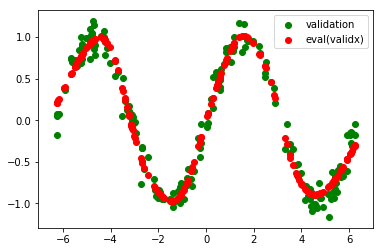

epoch 5600, validation MSE   1.64


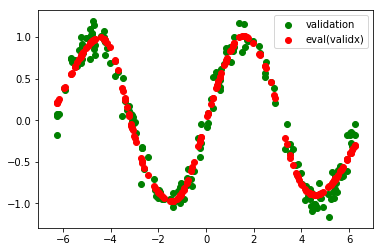

epoch 5700, validation MSE   1.62


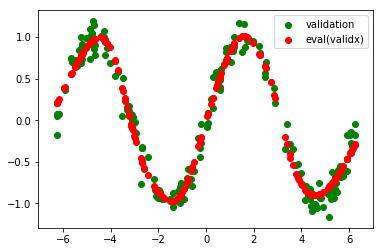

epoch 5800, validation MSE   1.61


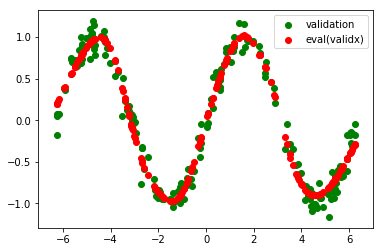

epoch 5900, validation MSE   1.60


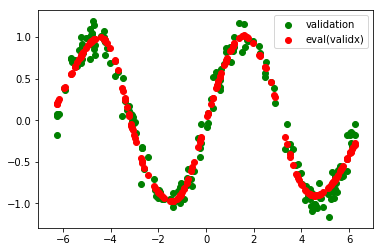

epoch 6000, validation MSE   1.58


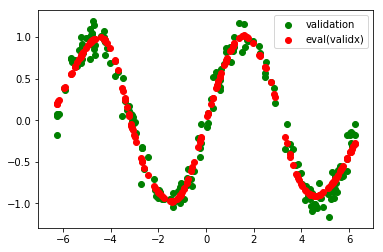

epoch 6100, validation MSE   1.57


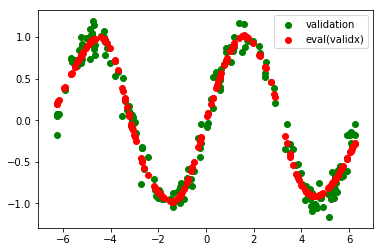

epoch 6200, validation MSE   1.56


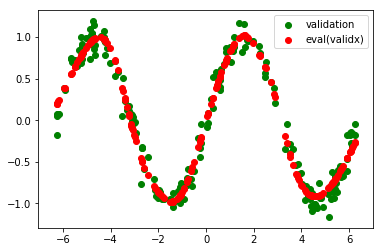

epoch 6300, validation MSE   1.55


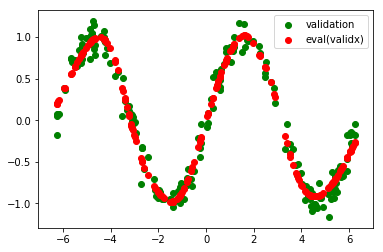

epoch 6400, validation MSE   1.54


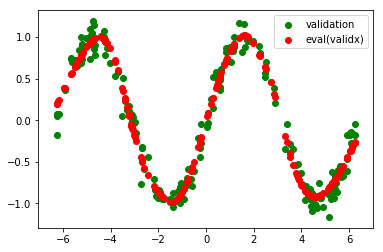

epoch 6500, validation MSE   1.53


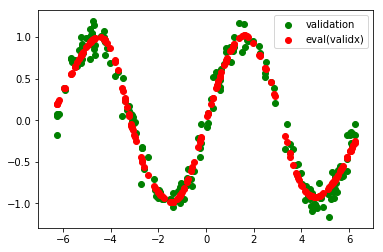

epoch 6600, validation MSE   1.52


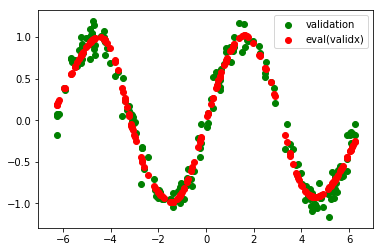

epoch 6700, validation MSE   1.51


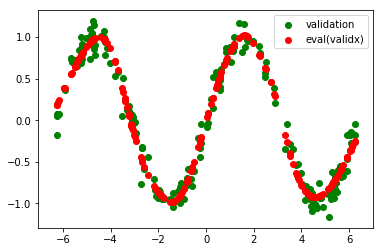

epoch 6800, validation MSE   1.50


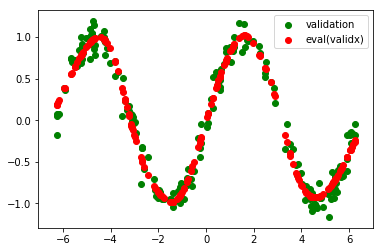

epoch 6900, validation MSE   1.49


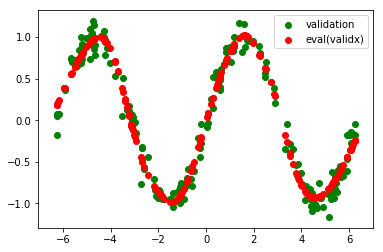

epoch 7000, validation MSE   1.48


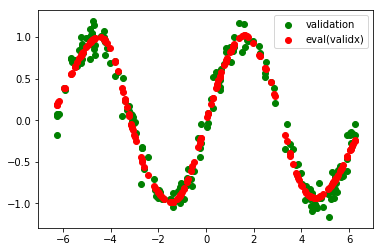

epoch 7100, validation MSE   1.47


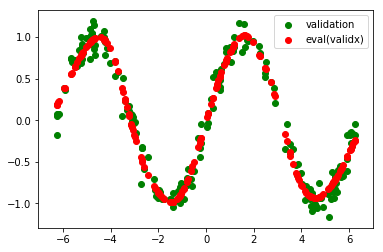

epoch 7200, validation MSE   1.46


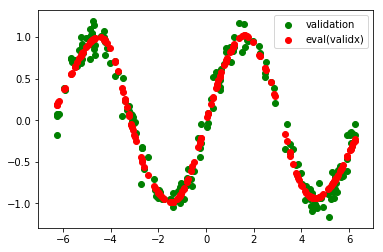

epoch 7300, validation MSE   1.46


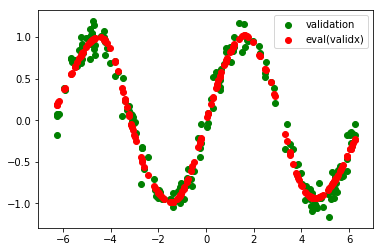

epoch 7400, validation MSE   1.45


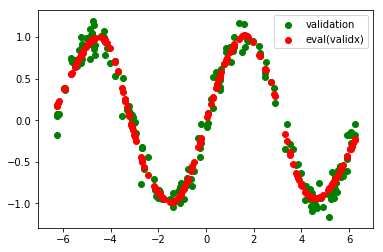

epoch 7500, validation MSE   1.44


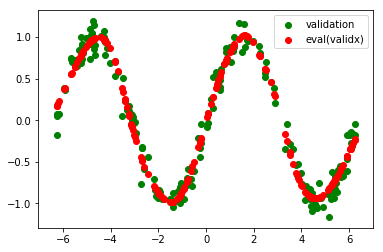

epoch 7600, validation MSE   1.43


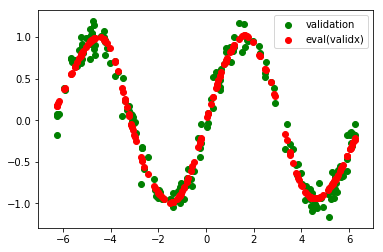

epoch 7700, validation MSE   1.43


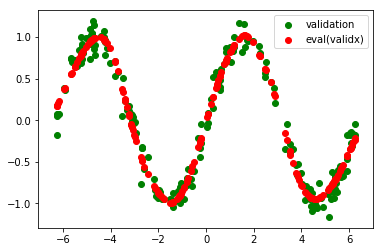

epoch 7800, validation MSE   1.42


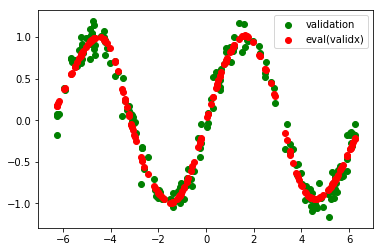

epoch 7900, validation MSE   1.41


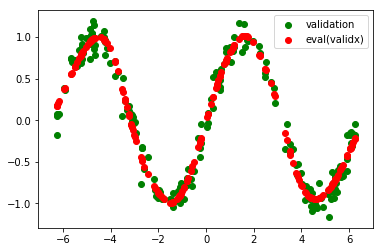

epoch 8000, validation MSE   1.41


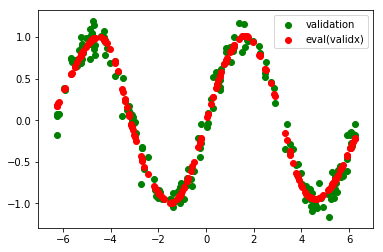

epoch 8100, validation MSE   1.40


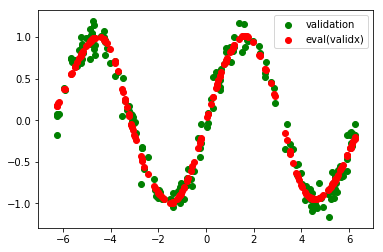

epoch 8200, validation MSE   1.40


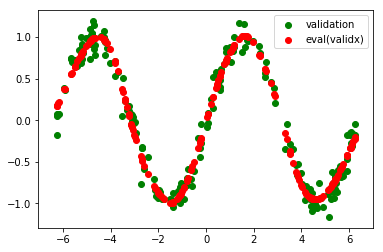

epoch 8300, validation MSE   1.39


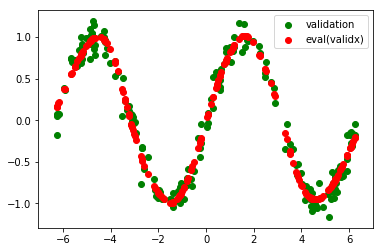

epoch 8400, validation MSE   1.39


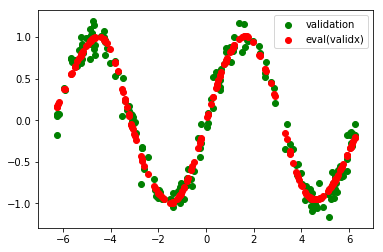

epoch 8500, validation MSE   1.38


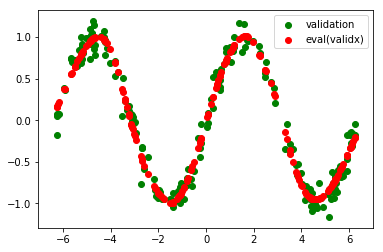

epoch 8600, validation MSE   1.38


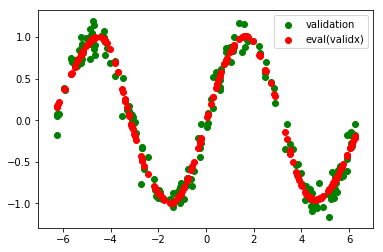

epoch 8700, validation MSE   1.37


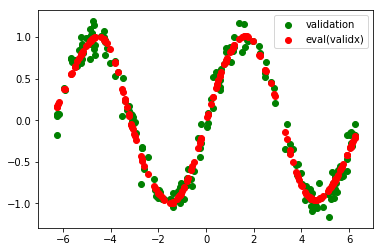

epoch 8800, validation MSE   1.37


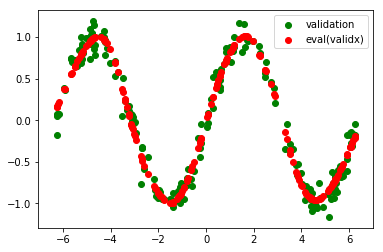

epoch 8900, validation MSE   1.36


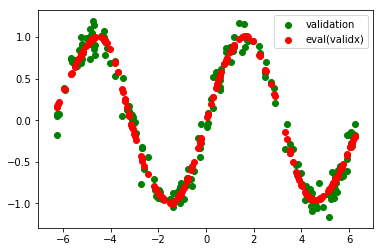

epoch 9000, validation MSE   1.36


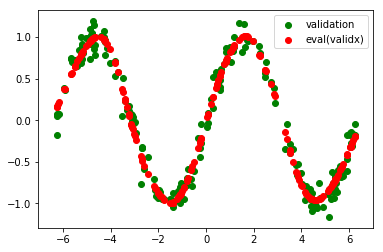

epoch 9100, validation MSE   1.35


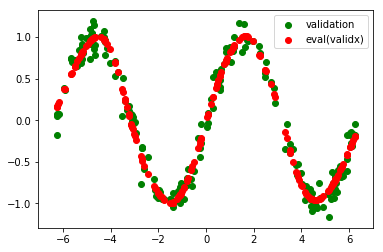

epoch 9200, validation MSE   1.35


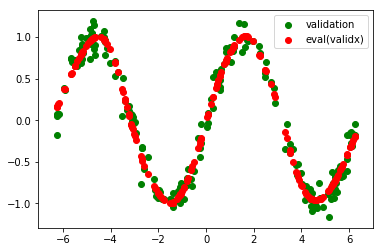

epoch 9300, validation MSE   1.35


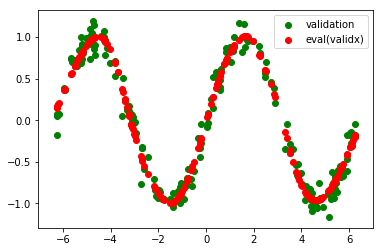

epoch 9400, validation MSE   1.34


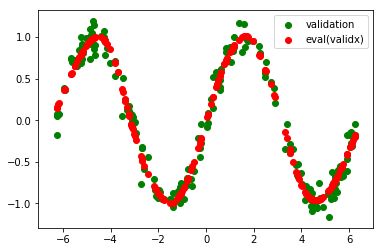

epoch 9500, validation MSE   1.34


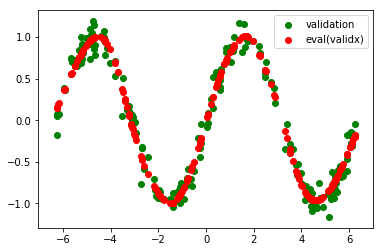

epoch 9600, validation MSE   1.33


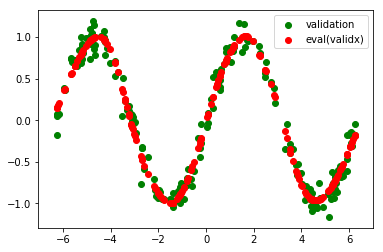

epoch 9700, validation MSE   1.33


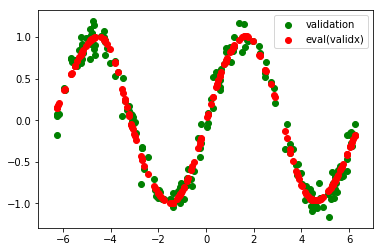

epoch 9800, validation MSE   1.33


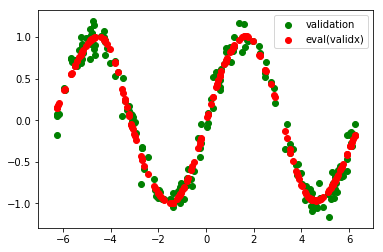

epoch 9900, validation MSE   1.32


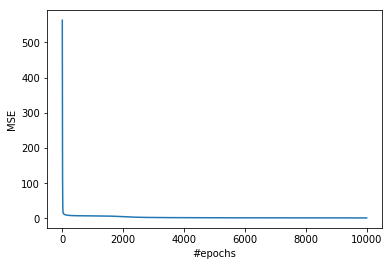

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    errors = []
    for i in range(NUM_EPOCHS):
        for start, end in zip(range(0, len(trainx), MINI_BATCH_SIZE), 
                              range(MINI_BATCH_SIZE, len(trainx), MINI_BATCH_SIZE)):
            sess.run(train_op, feed_dict={X: trainx[start:end], Y: trainy[start:end]})
        mse = sess.run(tf.nn.l2_loss(yhat - validy), feed_dict={X:validx})
        errors.append(mse)
        if i % 100 == 0: 
            result = sess.run(the_model, feed_dict={X:validx})
            plt.figure(1)
            plt.scatter(validx, validy, c='green', label='validation')
            plt.scatter(validx, result, c='red', label='eval(validx)')
            plt.legend()
            plt.show()
            print(f"epoch {i}, validation MSE {mse:6.2f}")
        
plt.xlabel('#epochs')
plt.ylabel('MSE')
plt.plot(errors);